<a id = "5" ></a>
# <span style="font-family:serif; font-size:28px;">Loading libraries and data</span>
<a id="loading"></a>

In [55]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import random
import time

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split


In [ ]:
def manipulate(data):
    #print(len(data))
    data = data.drop(['customerID'], axis = 1)
    data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    data.dropna(inplace = True)
    #print(len(data))
    return data

def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

def preprocess_data(data, time):
    data = data.apply(lambda x: object_to_int(x) if x.name != 'time' else x)
    
    #feature_cols
    feature_cols = categorical_cols + numerical_cols
    
    train = data[data['time']<=time].reset_index()
    test = data[data['time'] > time].reset_index()
    
    
    scaler= StandardScaler()

    train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
    test[numerical_cols] = scaler.transform(test[numerical_cols])

    return train, test

def roc_curve_show(y_test, y_pred_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(fpr, tpr, label=model_name,color = "r")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + 'ROC Curve',fontsize=16)
    plt.show()
    
def pr_curve_show(y_test, y_pred_prob, model_name):
    p, r, thresholds = precision_recall_curve(y_test, y_pred_prob)
    #plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(p, r, label=model_name,color = "r")
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(model_name + 'PR Curve',fontsize=16)
    plt.show()

    #adding timestamps

    
def str_time_prop(start, end, time_format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formatted in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))




In [67]:
import h2o
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from datetime import date

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid import H2OGridSearch
from h2o.automl import H2OAutoML

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import math
import os

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

from pandas import ExcelWriter

from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix, precision_recall_curve,auc
from sklearn.metrics import r2_score

# Load the H2O library and start up the H2O cluster locally on your machine
h2o.init(strict_version_check=False)


def calculate_cumm_dist(a):
    l = []
    for i in range(len(a)):
        if i == 0:
            l.append(a[i])
        else:
            x = sum(l)
            l.append(a[i]+l[-1])

    return l

def get_automl_class(train_data, valid_data, feature_cols,actualCol, _max_runtime_secs, _max_runtime_secs_per_model):
        aml = H2OAutoML(project_name=actualCol, balance_classes = True,
                    include_algos=['XGBoost','GBM','GLM','DRF', 'StackedEnsemble'], nfolds = 0, #,'DRF','GLM','StackedEnsemble'
                    max_runtime_secs=_max_runtime_secs, max_runtime_secs_per_model=_max_runtime_secs_per_model,
                    sort_metric='aucpr')
        aml.train(x=feature_cols,y=actualCol, training_frame=train_data, leaderboard_frame=valid_data, validation_frame=valid_data)
        lb = aml.leaderboard
        print ('Validation Scores')
        print(lb.head())
        best_model = aml.leader
        all_models = [h2o.get_model(id) for id in aml.leaderboard.as_data_frame().model_id]
        return best_model, all_models

def train_models(feature_cols, label_col, data, train_val_split):
    Train_Network_File = data[:int(len(data)*(1-train_val_split))]
    Val_Network_File = data[int(len(data)*(1-train_val_split)):]
    
    del(data)
    cols = list(set(feature_cols))
    cols.append(label_col)
    
    print('target_label' in feature_cols)
    print(len(feature_cols))
    print(len(cols))
    
    print('loading_train_frame...')
    train_data = h2o.H2OFrame(Train_Network_File[cols])
    print('loading_test_frame...')
    val_data = h2o.H2OFrame(Val_Network_File[cols])
    del(Train_Network_File)
    del(Val_Network_File)

    train_data[label_col] = train_data[label_col].asfactor()
    val_data[label_col] = val_data[label_col].asfactor()

    _max_runtime_secs = 2000   #max can be around 2600 secs
    _max_runtime_secs_per_model = 400  #max 600
    print('training_model')    
    
    best_model, all_models = get_automl_class(train_data, val_data, feature_cols, label_col, _max_runtime_secs, _max_runtime_secs_per_model)
    
    return train_data, val_data, best_model, all_models


def score(best_model, feature_cols, label_col, data_list):
    print("scoring")
    result_frames = []
    for data in data_list:
        df = h2o.H2OFrame(data[feature_cols])
        pred = best_model.predict(df)
        df["prediction"] = pred['p1']
        dt = df.as_data_frame()                 
        dt[label_col] = data[label_col]
        result_frames.append(dt)
                                     
    return result_frames

def save_predictions(dfs, save_location, split_name_list):
    print("save_predictions")
    for (i,df) in enumerate(dfs):
        df.to_csv(save_location + split_name_list[i]+'.csv', index = False)
        
def ks(data_df, label_col):
    print("ks")
    p = pd.DataFrame(data_df['prediction'])
    p.columns = ['pred']
    p['actuals'] = list(data_df[label_col])
    binned_x = pd.qcut(p['pred'], 10, duplicates = 'drop')
    p['binned'] = binned_x

    p_ = pd.DataFrame(p.groupby('binned',as_index='False').agg({'actuals':['sum','count']}))
    p_['binned'] = p_.index
    p_ = p_.reset_index(drop = True)
    p_.columns = ['Events','count','binned']


    p_['lower_limit'] = p_['binned'].apply(lambda x:float(str(x)[1:-1].split(', ')[0]))
    p_['upper_limit'] = p_['binned'].apply(lambda x:float(str(x)[1:-1].split(', ')[1]))
    p_ = p_.sort_values(by = 'upper_limit', ascending = False)
    p_['NonEvents'] = p_['count'] - p_['Events']
    sum_Events = p_['Events'].sum()
    sum_NonEvents = p_['NonEvents'].sum()
    p_['Events_Dist'] = p_['Events']/sum_Events
    p_['NonEvents_Dist'] = p_['NonEvents']/sum_NonEvents
    Events_Cumm = calculate_cumm_dist(list(p_['Events_Dist']))
    NonEvents_Cumm = calculate_cumm_dist(list(p_['NonEvents_Dist']))
    
    Events_Cumm_num = calculate_cumm_dist(list(p_['Events']))
    NonEvents_Cumm_num = calculate_cumm_dist(list(p_['NonEvents']))
    
    p_['Events_Cumm'] = Events_Cumm
    p_['NonEvents_Cumm'] = NonEvents_Cumm
    
    p_['Events_Cumm_num'] = Events_Cumm_num
    p_['NonEvents_Cumm_num'] = NonEvents_Cumm_num
    
    p_['KS'] = (p_['Events_Cumm'] - p_['NonEvents_Cumm'])*100
    p_['Precision'] = p_['Events_Cumm_num'] / (p_['Events_Cumm_num'] + p_['NonEvents_Cumm_num'])
    p_['Capture'] = p_['Events_Cumm']
    return(p_)
                                     

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,35 mins 32 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.1
H2O_cluster_version_age:,"1 year, 7 months and 15 days !!!"
H2O_cluster_name:,H2O_from_python_e106433_nxc0uq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,25.45 Gb
H2O_cluster_total_cores:,64
H2O_cluster_allowed_cores:,64
H2O_cluster_status:,"accepting new members, healthy"


<a id = "6" ></a>
# <span style="font-family:serif; font-size:28px;"> Data Manipulation and Remove Missing Values</span>
<a id = "Undertanding the data" ></a>

In [57]:
#loading data
data = pd.read_csv('../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
data = manipulate(data)

<a id = "10" ></a>
# <span style="font-family:serif; font-size:28px;"> Data Preprocessing</span>
<a id = "datapreprocessing" ></a>

In [82]:
numerical_cols = ['tenure', 'MonthlyCharges']
categorical_cols = ['Contract', 'PaperlessBilling', 'OnlineSecurity', 'TechSupport']        
feature_cols = categorical_cols + numerical_cols

<a id = "1111" ></a>
#### **Splitting the data into train and test sets**
<a id = "Split" ></a>

### Train Test Split

In [59]:
#add time valiable
start_date = "2021-06-01 00:00:00"
end_date = "2021-08-31 11:59:59"
num_dates = len(data)

data['time'] = random_dates(start_date, end_date, num_dates)

In [65]:
train, test = preprocess_data(data, "2021-07-31 23:59:59")
print(train.shape, test.shape)

(4682, 22) (2350, 22)


### Training model

In [68]:
train_data, val_data, best_model, all_models = train_models(feature_cols, 'Churn', train, 0.2)
all_models
#save_best_model(best_model, model_name_and_version)

feature_imp = get_feature_importance(best_model)
feature_imp

False
6
7
loading_train_frame...
Parse progress: |█████████████████████████████████████████████████████████| 100%
loading_test_frame...
Parse progress: |█████████████████████████████████████████████████████████| 100%
training_model
AutoML progress: |████████████████████████████████████████████████████████| 100%
Validation Scores


model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_2_AutoML_20220524_141111,0.702743,0.838846,0.442069,0.242871,0.378801,0.14349
GLM_1_AutoML_20220524_141111,0.698814,0.837693,0.445059,0.245558,0.378394,0.143182
XGBoost_3_AutoML_20220524_141111,0.684394,0.837503,0.446101,0.238785,0.37985,0.144286
XGBoost_1_AutoML_20220524_141111,0.651537,0.822255,0.469861,0.246633,0.390372,0.152391
DRF_1_AutoML_20220524_141111,0.63325,0.802162,0.785219,0.273706,0.412106,0.169832



get_feature_importance


,variable,relative_importance,scaled_importance,percentage
0,Contract,698.309509,1.000000,0.310945
1,MonthlyCharges,638.738342,0.914692,0.284419
2,tenure,536.379272,0.768111,0.238840
3,OnlineSecurity,159.361099,0.228210,0.070961
4,TechSupport,146.634430,0.209985,0.065294
5,PaperlessBilling,66.346146,0.095010,0.029543


In [71]:
all_models

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20220524_141111


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11786260083933991
RMSE: 0.34331123028432947
LogLoss: 0.3687814383300136
Mean Per-Class Error: 0.19688710927408937
AUC: 0.8829613979407314
AUCPR: 0.7244663700145055
Gini: 0.7659227958814627

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38186023993925616: 


,,0,1,Error,Rate
0,0,2349.0,416.0,0.1505,(416.0/2765.0)
1,1,243.0,737.0,0.248,(243.0/980.0)
2,Total,2592.0,1153.0,0.176,(659.0/3745.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.381860,0.691045,192.0
1,max f2,0.218585,0.777420,267.0
2,max f0point5,0.532022,0.690756,132.0
3,max accuracy,0.446441,0.833912,166.0
4,max precision,0.943511,1.000000,0.0
5,max recall,0.010249,1.000000,396.0
6,max specificity,0.943511,1.000000,0.0
7,max absolute_mcc,0.381860,0.572833,192.0
8,max min_per_class_accuracy,0.318902,0.801085,220.0
9,max mean_per_class_accuracy,0.347437,0.803113,208.0



Gains/Lift Table: Avg response rate: 26.17 %, avg score: 26.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010147,0.885309,3.519737,3.519737,0.921053,0.898207,0.921053,0.898207,0.035714,0.035714,251.973684,251.973684,0.034629
1,2,0.020027,0.851976,3.408301,3.464762,0.891892,0.868213,0.906667,0.883410,0.033673,0.069388,240.830116,246.476190,0.066856
2,3,0.030174,0.822804,3.620301,3.517067,0.947368,0.833475,0.920354,0.866618,0.036735,0.106122,262.030075,251.706700,0.102867
3,4,0.040053,0.799449,3.201737,3.439286,0.837838,0.812913,0.900000,0.853371,0.031633,0.137755,220.173745,243.928571,0.132330
4,5,0.050200,0.784741,3.318609,3.414894,0.868421,0.790929,0.893617,0.840749,0.033673,0.171429,231.860902,241.489362,0.164195
5,6,0.100401,0.688831,2.906725,3.160809,0.760638,0.735950,0.827128,0.788350,0.145918,0.317347,190.672492,216.080927,0.293839
6,7,0.150067,0.604852,2.465438,2.930669,0.645161,0.646964,0.766904,0.741557,0.122449,0.439796,146.543779,193.066853,0.392418
7,8,0.200000,0.524247,2.370512,2.790816,0.620321,0.565713,0.730307,0.697654,0.118367,0.558163,137.051184,179.081633,0.485107
8,9,0.300401,0.390421,1.819244,2.466095,0.476064,0.455814,0.645333,0.616826,0.182653,0.740816,81.924392,146.609524,0.596513
9,10,0.400000,0.265434,0.983531,2.096939,0.257373,0.325527,0.548732,0.544293,0.097959,0.838776,-1.646879,109.693878,0.594291




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.14349048253971952
RMSE: 0.37880137610589476
LogLoss: 0.4420687933383148
Mean Per-Class Error: 0.24287096417514364
AUC: 0.8388461963732861
AUCPR: 0.7027427817008105
Gini: 0.6776923927465721

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17103195190429688: 


,,0,1,Error,Rate
0,0,452.0,213.0,0.3203,(213.0/665.0)
1,1,45.0,227.0,0.1654,(45.0/272.0)
2,Total,497.0,440.0,0.2753,(258.0/937.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.171032,0.637640,258.0
1,max f2,0.094156,0.773700,308.0
2,max f0point5,0.633502,0.673077,81.0
3,max accuracy,0.523259,0.802561,114.0
4,max precision,0.904950,1.000000,0.0
5,max recall,0.011258,1.000000,394.0
6,max specificity,0.904950,1.000000,0.0
7,max absolute_mcc,0.521267,0.490620,115.0
8,max min_per_class_accuracy,0.270768,0.738971,217.0
9,max mean_per_class_accuracy,0.171032,0.757129,258.0



Gains/Lift Table: Avg response rate: 29.03 %, avg score: 26.85 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011740,0.886161,3.131684,3.131684,0.909091,0.894575,0.909091,0.894575,0.036765,0.036765,213.168449,213.168449,0.035261
1,2,0.020277,0.862482,3.014246,3.082237,0.875000,0.871911,0.894737,0.885032,0.025735,0.062500,201.424632,208.223684,0.059492
2,3,0.030950,0.835324,3.100368,3.088489,0.900000,0.850180,0.896552,0.873014,0.033088,0.095588,210.036765,208.848884,0.091077
3,4,0.040555,0.826735,3.444853,3.172891,1.000000,0.829724,0.921053,0.862761,0.033088,0.128676,244.485294,217.289087,0.124165
4,5,0.050160,0.816565,3.444853,3.224969,1.000000,0.821582,0.936170,0.854876,0.033088,0.161765,244.485294,222.496871,0.157253
5,6,0.100320,0.726881,2.638611,2.931790,0.765957,0.768533,0.851064,0.811704,0.132353,0.294118,163.861076,193.178974,0.273065
6,7,0.150480,0.630808,2.345432,2.736337,0.680851,0.684577,0.794326,0.769329,0.117647,0.411765,134.543179,173.633709,0.368156
7,8,0.200640,0.540635,1.759074,2.492021,0.510638,0.584226,0.723404,0.723053,0.088235,0.500000,75.907384,149.202128,0.421805
8,9,0.300961,0.391191,1.172716,2.052253,0.340426,0.460266,0.595745,0.635457,0.117647,0.617647,17.271589,105.225282,0.446218
9,10,0.400213,0.259382,1.222367,1.846441,0.354839,0.326158,0.536000,0.558751,0.121324,0.738971,22.236717,84.644118,0.477316




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 14:11:23,0.015 sec,0.0,0.500000,0.693147,0.500000,0.261682,1.000000,0.738318,0.500000,0.693147,0.500000,0.290288,1.000000,0.709712
1,,2022-05-24 14:11:25,2.217 sec,5.0,0.369817,0.433806,0.858124,0.666423,3.388814,0.201335,0.379760,0.452642,0.846290,0.709112,3.242215,0.220918
2,,2022-05-24 14:11:25,2.543 sec,10.0,0.356390,0.395821,0.865266,0.684351,3.419173,0.199733,0.370895,0.427000,0.849643,0.711791,3.100368,0.208111
3,,2022-05-24 14:11:27,3.803 sec,15.0,0.352049,0.385422,0.870843,0.696450,3.419173,0.206676,0.371159,0.426499,0.848355,0.719267,3.100368,0.219851
4,,2022-05-24 14:11:27,4.085 sec,20.0,0.349085,0.379161,0.875212,0.705879,3.496201,0.180774,0.374665,0.434258,0.844452,0.715944,3.100368,0.273212
5,,2022-05-24 14:11:27,4.416 sec,25.0,0.345255,0.372616,0.880162,0.717823,3.519737,0.178905,0.377051,0.439028,0.840972,0.708442,3.444853,0.266809
6,,2022-05-24 14:11:27,4.741 sec,30.0,0.343311,0.368781,0.882961,0.724466,3.519737,0.175968,0.378801,0.442069,0.838846,0.702743,3.131684,0.275347



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,698.309509,1.000000,0.310945
1,MonthlyCharges,638.738342,0.914692,0.284419
2,tenure,536.379272,0.768111,0.238840
3,OnlineSecurity,159.361099,0.228210,0.070961
4,TechSupport,146.634430,0.209985,0.065294
5,PaperlessBilling,66.346146,0.095010,0.029543


Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_20220524_141111


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,Ridge ( lambda = 0.001255 ),"nlambda = 30, lambda.max = 17.245, lambda.min = 0.001255, lambda.1...",6,6,5,automl_training_py_421_sid_bd69




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.13669075409405937
RMSE: 0.3697171271310803
LogLoss: 0.41801332865201235
Null degrees of freedom: 3744
Residual degrees of freedom: 3738
Null deviance: 4305.3205060337
Residual deviance: 3130.919831603573
AIC: 3144.919831603573
AUC: 0.8423384507510057
AUCPR: 0.6294232563703559
Gini: 0.6846769015020113

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35953217608055094: 


,,0,1,Error,Rate
0,0,2221.0,544.0,0.1967,(544.0/2765.0)
1,1,274.0,706.0,0.2796,(274.0/980.0)
2,Total,2495.0,1250.0,0.2184,(818.0/3745.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.359532,0.633184,193.0
1,max f2,0.146942,0.756464,293.0
2,max f0point5,0.504929,0.607820,128.0
3,max accuracy,0.534588,0.795995,113.0
4,max precision,0.816211,1.000000,0.0
5,max recall,0.006753,1.000000,396.0
6,max specificity,0.816211,1.000000,0.0
7,max absolute_mcc,0.359532,0.488115,193.0
8,max min_per_class_accuracy,0.299790,0.763834,217.0
9,max mean_per_class_accuracy,0.235337,0.769614,247.0



Gains/Lift Table: Avg response rate: 26.17 %, avg score: 26.17 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010147,0.755146,3.016917,3.016917,0.789474,0.775072,0.789474,0.775072,0.030612,0.030612,201.691729,201.691729,0.027719
1,2,0.020027,0.739922,3.201737,3.108095,0.837838,0.746557,0.813333,0.761005,0.031633,0.062245,220.173745,210.809524,0.057182
2,3,0.030174,0.719361,2.916353,3.043616,0.763158,0.727872,0.796460,0.749863,0.029592,0.091837,191.635338,204.361568,0.083518
3,4,0.040053,0.702248,2.582046,2.929762,0.675676,0.711455,0.766667,0.740389,0.025510,0.117347,158.204633,192.976190,0.104689
4,5,0.050200,0.694132,3.218045,2.988032,0.842105,0.697362,0.781915,0.731692,0.032653,0.150000,221.804511,198.803191,0.135172
5,6,0.100134,0.646032,2.574866,2.782000,0.673797,0.669839,0.728000,0.700848,0.128571,0.278571,157.486631,178.200000,0.241682
6,7,0.150067,0.574839,2.186593,2.583884,0.572193,0.612428,0.676157,0.671427,0.109184,0.387755,118.659282,158.388409,0.321932
7,8,0.200000,0.522712,2.023109,2.443878,0.529412,0.548652,0.639519,0.640774,0.101020,0.488776,102.310924,144.387755,0.391126
8,9,0.300134,0.394042,1.824095,2.237100,0.477333,0.456429,0.585409,0.579271,0.182653,0.671429,82.409524,123.709964,0.502893
9,10,0.400000,0.275517,1.195474,1.977041,0.312834,0.334499,0.517356,0.518160,0.119388,0.790816,19.547364,97.704082,0.529334




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.14318178198018613
RMSE: 0.3783936864962022
LogLoss: 0.44505870576179574
Null degrees of freedom: 936
Residual degrees of freedom: 930
Null deviance: 1132.7963384651757
Residual deviance: 834.0400145976051
AIC: 848.0400145976051
AUC: 0.8376934984520125
AUCPR: 0.6988144327021247
Gini: 0.6753869969040249

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37432632525815757: 


,,0,1,Error,Rate
0,0,556.0,109.0,0.1639,(109.0/665.0)
1,1,89.0,183.0,0.3272,(89.0/272.0)
2,Total,645.0,292.0,0.2113,(198.0/937.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.374326,0.648936,174.0
1,max f2,0.134385,0.754310,290.0
2,max f0point5,0.515470,0.682692,115.0
3,max accuracy,0.515470,0.807898,115.0
4,max precision,0.818153,1.000000,0.0
5,max recall,0.005345,1.000000,398.0
6,max specificity,0.818153,1.000000,0.0
7,max absolute_mcc,0.473864,0.507965,133.0
8,max min_per_class_accuracy,0.262487,0.751880,216.0
9,max mean_per_class_accuracy,0.374326,0.754442,174.0



Gains/Lift Table: Avg response rate: 29.03 %, avg score: 25.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010672,0.774624,3.444853,3.444853,1.000000,0.794150,1.000000,0.794150,0.036765,0.036765,244.485294,244.485294,0.036765
1,2,0.020277,0.746117,3.062092,3.263545,0.888889,0.763228,0.947368,0.779502,0.029412,0.066176,206.209150,226.354489,0.064673
2,3,0.030950,0.725816,2.755882,3.088489,0.800000,0.735356,0.896552,0.764280,0.029412,0.095588,175.588235,208.848884,0.091077
3,4,0.040555,0.711290,2.679330,2.991583,0.777778,0.717491,0.868421,0.753198,0.025735,0.121324,167.933007,199.158282,0.113805
4,5,0.050160,0.699338,3.062092,3.005084,0.888889,0.704165,0.872340,0.743809,0.029412,0.150735,206.209150,200.508448,0.141713
5,6,0.100320,0.662605,3.005084,3.005084,0.872340,0.678994,0.872340,0.711402,0.150735,0.301471,200.508448,200.508448,0.283425
6,7,0.150480,0.577879,1.905663,2.638611,0.553191,0.616665,0.765957,0.679823,0.095588,0.397059,90.566333,163.861076,0.347435
7,8,0.200640,0.520702,2.198842,2.528669,0.638298,0.544553,0.734043,0.646005,0.110294,0.507353,119.884230,152.866865,0.432165
8,9,0.299893,0.387140,1.444616,2.169890,0.419355,0.452950,0.629893,0.582112,0.143382,0.650735,44.461575,116.988958,0.494344
9,10,0.400213,0.252984,1.026126,1.883186,0.297872,0.310141,0.546667,0.513938,0.102941,0.753676,2.612641,88.318627,0.498037




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,training_rmse,training_logloss,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 14:11:36,0.000 sec,2,.17E2,7,1.138034,1.196913,,,...,,,,,,,,,,
1,,2022-05-24 14:11:36,0.048 sec,4,.11E2,7,1.131362,1.189975,,,...,,,,,,,,,,
2,,2022-05-24 14:11:37,0.315 sec,6,.67E1,7,1.121202,1.179413,,,...,,,,,,,,,,
3,,2022-05-24 14:11:37,0.327 sec,8,.41E1,7,1.106210,1.163834,,,...,,,,,,,,,,
4,,2022-05-24 14:11:37,0.363 sec,10,.26E1,7,1.085072,1.141886,,,...,,,,,,,,,,
5,,2022-05-24 14:11:37,0.402 sec,12,.16E1,7,1.057132,1.112914,,,...,,,,,,,,,,
6,,2022-05-24 14:11:37,0.555 sec,14,.99E0,7,1.023161,1.077769,,,...,,,,,,,,,,
7,,2022-05-24 14:11:37,0.561 sec,16,.61E0,7,0.985830,1.039300,,,...,,,,,,,,,,
8,,2022-05-24 14:11:37,0.574 sec,18,.38E0,7,0.948973,1.001563,,,...,,,,,,,,,,
9,,2022-05-24 14:11:37,0.583 sec,20,.24E0,7,0.916153,0.968274,,,...,,,,,,,,,,



See the whole table with table.as_data_frame()
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20220524_141111


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11313268964551575
RMSE: 0.3363520323195859
LogLoss: 0.3538707299360269
Mean Per-Class Error: 0.18274347713769057
AUC: 0.8961896150865409
AUCPR: 0.7443782890296783
Gini: 0.7923792301730819

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.359024359120263: 


,,0,1,Error,Rate
0,0,2334.0,431.0,0.1559,(431.0/2765.0)
1,1,212.0,768.0,0.2163,(212.0/980.0)
2,Total,2546.0,1199.0,0.1717,(643.0/3745.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.359024,0.704911,192.0
1,max f2,0.200860,0.791005,263.0
2,max f0point5,0.525544,0.709147,120.0
3,max accuracy,0.473795,0.841656,142.0
4,max precision,0.909972,1.000000,0.0
5,max recall,0.011068,1.000000,390.0
6,max specificity,0.909972,1.000000,0.0
7,max absolute_mcc,0.359024,0.591481,192.0
8,max min_per_class_accuracy,0.321420,0.814828,208.0
9,max mean_per_class_accuracy,0.319685,0.817257,209.0



Gains/Lift Table: Avg response rate: 26.17 %, avg score: 25.97 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010147,0.873620,3.419173,3.419173,0.894737,0.890642,0.894737,0.890642,0.034694,0.034694,241.917293,241.917293,0.033247
1,2,0.020027,0.820983,3.511583,3.464762,0.918919,0.842496,0.906667,0.866890,0.034694,0.069388,251.158301,246.476190,0.066856
2,3,0.030441,0.804966,3.331502,3.419173,0.871795,0.809118,0.894737,0.847126,0.034694,0.104082,233.150183,241.917293,0.099742
3,4,0.040053,0.790696,3.290675,3.388333,0.861111,0.795755,0.886667,0.834797,0.031633,0.135714,229.067460,238.833333,0.129566
4,5,0.050734,0.761877,3.439286,3.399060,0.900000,0.777486,0.889474,0.822732,0.036735,0.172449,243.928571,239.906015,0.164854
5,6,0.100134,0.666483,2.995174,3.199810,0.783784,0.712571,0.837333,0.768386,0.147959,0.320408,199.517375,219.980952,0.298347
6,7,0.150601,0.589494,2.608277,3.001583,0.682540,0.626481,0.785461,0.720832,0.131633,0.452041,160.827664,200.158308,0.408280
7,8,0.200267,0.516314,2.444892,2.863524,0.639785,0.552452,0.749333,0.679074,0.121429,0.573469,144.489247,186.352381,0.505477
8,9,0.300401,0.380914,1.824095,2.517048,0.477333,0.448734,0.658667,0.602294,0.182653,0.756122,82.409524,151.704762,0.617244
9,10,0.400000,0.264441,1.045002,2.150510,0.273458,0.322158,0.562750,0.532541,0.104082,0.860204,4.500191,115.051020,0.623314




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.14428621049148566
RMSE: 0.37985024745481694
LogLoss: 0.4461011467150056
Mean Per-Class Error: 0.23878538257408222
AUC: 0.8375027642636003
AUCPR: 0.6843935179841134
Gini: 0.6750055285272005

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2836812138557434: 


,,0,1,Error,Rate
0,0,521.0,144.0,0.2165,(144.0/665.0)
1,1,71.0,201.0,0.261,(71.0/272.0)
2,Total,592.0,345.0,0.2295,(215.0/937.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.283681,0.651540,202.0
1,max f2,0.090380,0.767132,308.0
2,max f0point5,0.568352,0.658163,100.0
3,max accuracy,0.568352,0.796158,100.0
4,max precision,0.899298,1.000000,0.0
5,max recall,0.007950,1.000000,391.0
6,max specificity,0.899298,1.000000,0.0
7,max absolute_mcc,0.293452,0.492543,198.0
8,max min_per_class_accuracy,0.252425,0.757353,214.0
9,max mean_per_class_accuracy,0.283681,0.761215,202.0



Gains/Lift Table: Avg response rate: 29.03 %, avg score: 26.15 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011740,0.877778,3.131684,3.131684,0.909091,0.888316,0.909091,0.888316,0.036765,0.036765,213.168449,213.168449,0.035261
1,2,0.021345,0.835889,3.062092,3.100368,0.888889,0.847551,0.900000,0.869972,0.029412,0.066176,206.209150,210.036765,0.063169
2,3,0.030950,0.808538,3.062092,3.088489,0.888889,0.817411,0.896552,0.853660,0.029412,0.095588,206.209150,208.848884,0.091077
3,4,0.040555,0.804123,3.062092,3.082237,0.888889,0.805049,0.894737,0.842147,0.029412,0.125000,206.209150,208.223684,0.118985
4,5,0.052295,0.791634,2.818516,3.023034,0.818182,0.794372,0.877551,0.831422,0.033088,0.158088,181.851604,202.303421,0.149066
5,6,0.100320,0.692479,2.526225,2.785200,0.733333,0.742547,0.808511,0.788875,0.121324,0.279412,152.622549,178.520025,0.252344
6,7,0.151547,0.620034,2.224801,2.595769,0.645833,0.654760,0.753521,0.743540,0.113971,0.393382,122.480086,159.576947,0.340751
7,8,0.200640,0.530189,1.722426,2.382079,0.500000,0.582309,0.691489,0.704090,0.084559,0.477941,72.242647,138.207916,0.390723
8,9,0.299893,0.378581,1.629823,2.133112,0.473118,0.446508,0.619217,0.618841,0.161765,0.639706,62.982290,113.311179,0.478804
9,10,0.400213,0.242293,1.209363,1.901559,0.351064,0.305413,0.552000,0.540275,0.121324,0.761029,20.936327,90.155882,0.508398




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 14:11:30,0.916 sec,0.0,0.500000,0.693147,0.500000,0.261682,1.000000,0.738318,0.500000,0.693147,0.500000,0.290288,1.000000,0.709712
1,,2022-05-24 14:11:31,2.040 sec,5.0,0.368386,0.431452,0.862856,0.679457,3.396825,0.194660,0.381194,0.456030,0.842581,0.709127,3.444853,0.194237
2,,2022-05-24 14:11:31,2.228 sec,10.0,0.354059,0.391012,0.871260,0.694625,3.527473,0.192523,0.373385,0.431598,0.846335,0.708504,3.444853,0.198506
3,,2022-05-24 14:11:32,2.898 sec,15.0,0.350091,0.380275,0.876384,0.704706,3.474026,0.186115,0.375371,0.436305,0.842758,0.702050,3.100368,0.213447
4,,2022-05-24 14:11:32,3.133 sec,20.0,0.345269,0.370796,0.883157,0.718772,3.457483,0.181575,0.376120,0.438089,0.842302,0.699660,3.100368,0.212380
5,,2022-05-24 14:11:32,3.338 sec,25.0,0.340280,0.361358,0.890427,0.733460,3.448606,0.168758,0.378943,0.442954,0.839056,0.686555,3.131684,0.227321
6,,2022-05-24 14:11:33,3.656 sec,30.0,0.336352,0.353871,0.896190,0.744378,3.419173,0.171696,0.379850,0.446101,0.837503,0.684394,3.131684,0.229456



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,787.076721,1.000000,0.289247
1,MonthlyCharges,737.705444,0.937273,0.271103
2,Contract,679.423157,0.863224,0.249685
3,TechSupport,258.619354,0.328582,0.095041
4,OnlineSecurity,176.911499,0.224770,0.065014
5,PaperlessBilling,81.389847,0.103408,0.029910


Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20220524_141111


Model Summary: 


,,number_of_trees
0,,30.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10695485145624924
RMSE: 0.32703952583173984
LogLoss: 0.33893326187577066
Mean Per-Class Error: 0.17353397055024544
AUC: 0.9053804849245304
AUCPR: 0.7750286168354296
Gini: 0.8107609698490608

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41588686779141426: 


,,0,1,Error,Rate
0,0,2447.0,318.0,0.115,(318.0/2765.0)
1,1,249.0,731.0,0.2541,(249.0/980.0)
2,Total,2696.0,1049.0,0.1514,(567.0/3745.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.415887,0.720552,182.0
1,max f2,0.210121,0.800288,268.0
2,max f0point5,0.546928,0.730769,131.0
3,max accuracy,0.455344,0.852336,164.0
4,max precision,0.927827,1.000000,0.0
5,max recall,0.014125,1.000000,387.0
6,max specificity,0.927827,1.000000,0.0
7,max absolute_mcc,0.415887,0.617561,182.0
8,max min_per_class_accuracy,0.327137,0.826401,218.0
9,max mean_per_class_accuracy,0.327137,0.826466,218.0



Gains/Lift Table: Avg response rate: 26.17 %, avg score: 26.28 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010414,0.884743,3.625458,3.625458,0.948718,0.901066,0.948718,0.901066,0.037755,0.037755,262.545788,262.545788,0.037032
1,2,0.020027,0.861820,3.396825,3.515714,0.888889,0.872790,0.920000,0.887493,0.032653,0.070408,239.682540,251.571429,0.068238
2,3,0.030174,0.838192,3.720865,3.584703,0.973684,0.849432,0.938053,0.874694,0.037755,0.108163,272.086466,258.470291,0.105632
3,4,0.040320,0.820416,3.720865,3.618969,0.973684,0.830236,0.947020,0.863506,0.037755,0.145918,272.086466,261.896878,0.143025
4,5,0.050200,0.795303,3.511583,3.597834,0.918919,0.810271,0.941489,0.853029,0.034694,0.180612,251.158301,259.783435,0.176634
5,6,0.100134,0.705338,3.004011,3.301714,0.786096,0.751407,0.864000,0.802353,0.150000,0.330612,200.401070,230.171429,0.312167
6,7,0.150067,0.613562,2.840527,3.148259,0.743316,0.659946,0.823843,0.754969,0.141837,0.472449,184.052712,214.825877,0.436644
7,8,0.200000,0.535559,2.370512,2.954082,0.620321,0.575428,0.773031,0.710143,0.118367,0.590816,137.051184,195.408163,0.529334
8,9,0.300134,0.385302,1.762952,2.556685,0.461333,0.458651,0.669039,0.626238,0.176531,0.767347,76.295238,155.668531,0.632808
9,10,0.400000,0.250943,1.103514,2.193878,0.288770,0.318642,0.574099,0.549442,0.110204,0.877551,10.351413,119.387755,0.646810




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.15239055596049123
RMSE: 0.3903723299114465
LogLoss: 0.4698611895966938
Mean Per-Class Error: 0.24663312693498451
AUC: 0.8222550862450244
AUCPR: 0.6515368905064053
Gini: 0.6445101724900488

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1875298172235489: 


,,0,1,Error,Rate
0,0,469.0,196.0,0.2947,(196.0/665.0)
1,1,54.0,218.0,0.1985,(54.0/272.0)
2,Total,523.0,414.0,0.2668,(250.0/937.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.187530,0.635569,257.0
1,max f2,0.080799,0.756024,322.0
2,max f0point5,0.613645,0.650224,98.0
3,max accuracy,0.613645,0.791889,98.0
4,max precision,0.926516,1.000000,0.0
5,max recall,0.006501,1.000000,395.0
6,max specificity,0.926516,1.000000,0.0
7,max absolute_mcc,0.187530,0.463153,257.0
8,max min_per_class_accuracy,0.234936,0.739850,238.0
9,max mean_per_class_accuracy,0.187530,0.753367,257.0



Gains/Lift Table: Avg response rate: 29.03 %, avg score: 26.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010672,0.886102,2.411397,2.411397,0.700000,0.905912,0.700000,0.905912,0.025735,0.025735,141.139706,141.139706,0.021224
1,2,0.020277,0.877081,3.444853,2.900929,1.000000,0.882524,0.842105,0.894834,0.033088,0.058824,244.485294,190.092879,0.054312
2,3,0.032017,0.853884,3.131684,2.985539,0.909091,0.863392,0.866667,0.883305,0.036765,0.095588,213.168449,198.553922,0.089573
3,4,0.040555,0.842046,3.014246,2.991583,0.875000,0.848880,0.868421,0.876058,0.025735,0.121324,201.424632,199.158282,0.113805
4,5,0.051227,0.820954,3.100368,3.014246,0.900000,0.829681,0.875000,0.866396,0.033088,0.154412,210.036765,201.424632,0.145389
5,6,0.100320,0.732928,2.396419,2.711906,0.695652,0.779100,0.787234,0.823677,0.117647,0.272059,139.641944,171.190551,0.241984
6,7,0.150480,0.645812,2.492021,2.638611,0.723404,0.690865,0.765957,0.779406,0.125000,0.397059,149.202128,163.861076,0.347435
7,8,0.200640,0.543285,1.539190,2.363755,0.446809,0.588406,0.686170,0.731656,0.077206,0.474265,53.918961,136.375548,0.385543
8,9,0.299893,0.364275,1.222367,1.986001,0.354839,0.456931,0.576512,0.640733,0.121324,0.595588,22.236717,98.600063,0.416641
9,10,0.400213,0.234648,1.465895,1.855627,0.425532,0.299105,0.538667,0.555098,0.147059,0.742647,46.589487,85.562745,0.482497




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 14:11:13,1.956 sec,0.0,0.500000,0.693147,0.500000,0.261682,1.000000,0.738318,0.500000,0.693147,0.500000,0.290288,1.000000,0.709712
1,,2022-05-24 14:11:15,4.198 sec,5.0,0.359992,0.417639,0.875932,0.712875,3.387175,0.191722,0.381666,0.455962,0.838409,0.694047,3.444853,0.256137
2,,2022-05-24 14:11:17,6.472 sec,10.0,0.343884,0.374155,0.885047,0.734645,3.720865,0.186382,0.378740,0.442782,0.835512,0.690110,3.444853,0.242263
3,,2022-05-24 14:11:18,6.781 sec,15.0,0.340712,0.364676,0.888156,0.737554,3.639456,0.180240,0.380288,0.446869,0.833945,0.686987,3.444853,0.252935
4,,2022-05-24 14:11:18,7.047 sec,20.0,0.335329,0.354509,0.894761,0.749454,3.519737,0.167156,0.384089,0.455923,0.829462,0.675994,3.131684,0.268943
5,,2022-05-24 14:11:18,7.457 sec,25.0,0.331597,0.347064,0.899235,0.761149,3.635017,0.170895,0.388937,0.465901,0.824303,0.661160,2.755882,0.276414
6,,2022-05-24 14:11:20,9.102 sec,30.0,0.327040,0.338933,0.905380,0.775029,3.625458,0.151402,0.390372,0.469861,0.822255,0.651537,2.411397,0.266809



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,999.299805,1.000000,0.353792
1,tenure,952.580383,0.953248,0.337251
2,OnlineSecurity,362.396362,0.362650,0.128303
3,Contract,258.217316,0.258398,0.091419
4,TechSupport,170.070999,0.170190,0.060212
5,PaperlessBilling,81.975487,0.082033,0.029023


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20220524_141111


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,514507.0,20.0,20.0,20.0,749.0,865.0,814.26




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07542527616528626
RMSE: 0.2746366256807097
LogLoss: 0.4577823158405667
Mean Per-Class Error: 0.08394411319980577
AUC: 0.9563086318849965
AUCPR: 0.9298332004740626
Gini: 0.912617263769993

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38942617589918577: 


,,0,1,Error,Rate
0,0,2398.0,367.0,0.1327,(367.0/2765.0)
1,1,97.0,2662.0,0.0352,(97.0/2759.0)
2,Total,2495.0,3029.0,0.084,(464.0/5524.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.389426,0.919834,239.0
1,max f2,0.269014,0.961713,282.0
2,max f0point5,0.534000,0.903957,192.0
3,max accuracy,0.389426,0.916003,239.0
4,max precision,1.000000,0.945205,0.0
5,max recall,0.184364,1.000000,309.0
6,max specificity,1.000000,0.986980,0.0
7,max absolute_mcc,0.329597,0.836193,259.0
8,max min_per_class_accuracy,0.529250,0.901989,194.0
9,max mean_per_class_accuracy,0.389426,0.916056,239.0



Gains/Lift Table: Avg response rate: 49.95 %, avg score: 47.73 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.118936,1.000000,1.892466,1.892466,0.945205,1.000000,0.945205,1.000000,0.225082,0.225082,89.246650,89.246650,0.212062
1,2,0.150434,0.983803,1.887107,1.891344,0.942529,0.988433,0.944645,0.997578,0.059442,0.284523,88.710719,89.134433,0.267887
2,3,0.200036,0.935038,1.885259,1.889835,0.941606,0.965705,0.943891,0.989675,0.093512,0.378036,88.525939,88.983549,0.355612
3,4,0.303584,0.821989,1.830660,1.869652,0.914336,0.865242,0.933810,0.947232,0.189561,0.567597,83.065974,86.965151,0.527452
4,5,0.402064,0.697776,1.810790,1.855234,0.904412,0.756745,0.926610,0.900575,0.178325,0.745922,81.079035,85.523437,0.686971
5,6,0.500000,0.524780,1.602480,1.805727,0.800370,0.614456,0.901883,0.844532,0.156941,0.902863,60.247994,80.572671,0.804853
6,7,0.599928,0.233604,0.953935,1.663847,0.476449,0.383487,0.831020,0.767738,0.095324,0.998188,-4.606531,66.384705,0.795656
7,8,0.701122,0.066328,0.017909,1.426285,0.008945,0.130866,0.712368,0.675816,0.001812,1.000000,-98.209146,42.628453,0.597107
8,9,0.800145,0.015889,0.000000,1.249774,0.000000,0.033241,0.624208,0.596294,0.000000,1.000000,-100.000000,24.977376,0.399277
9,10,1.000000,0.000000,0.000000,1.000000,0.000000,0.001069,0.499457,0.477335,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.1698316057359876
RMSE: 0.4121063039265325
LogLoss: 0.7852185511123451
Mean Per-Class Error: 0.2735377045555064
AUC: 0.8021616541353384
AUCPR: 0.6332498833161495
Gini: 0.6043233082706767

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12850830350131578: 


,,0,1,Error,Rate
0,0,477.0,188.0,0.2827,(188.0/665.0)
1,1,72.0,200.0,0.2647,(72.0/272.0)
2,Total,549.0,388.0,0.2775,(260.0/937.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.128508,0.606061,253.0
1,max f2,0.033938,0.738739,339.0
2,max f0point5,0.436180,0.606343,137.0
3,max accuracy,0.462724,0.773746,131.0
4,max precision,0.931815,0.918367,25.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,1.000000,0.996992,0.0
7,max absolute_mcc,0.246919,0.439064,191.0
8,max min_per_class_accuracy,0.135732,0.720588,249.0
9,max mean_per_class_accuracy,0.115941,0.726462,261.0



Gains/Lift Table: Avg response rate: 29.03 %, avg score: 22.99 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010672,0.995982,2.411397,2.411397,0.700000,0.999118,0.700000,0.999118,0.025735,0.025735,141.139706,141.139706,0.021224
1,2,0.020277,0.992965,3.444853,2.900929,1.000000,0.995082,0.842105,0.997206,0.033088,0.058824,244.485294,190.092879,0.054312
2,3,0.030950,0.987541,3.100368,2.969701,0.900000,0.989853,0.862069,0.994670,0.033088,0.091912,210.036765,196.970081,0.085897
3,4,0.040555,0.976374,3.444853,3.082237,1.000000,0.984321,0.894737,0.992219,0.033088,0.125000,244.485294,208.223684,0.118985
4,5,0.050160,0.933270,3.444853,3.151674,1.000000,0.948256,0.914894,0.983801,0.033088,0.158088,244.485294,215.167397,0.152073
5,6,0.100320,0.827815,2.345432,2.748553,0.680851,0.880467,0.797872,0.932134,0.117647,0.275735,134.543179,174.855288,0.247164
6,7,0.150480,0.616291,1.539190,2.345432,0.446809,0.714415,0.680851,0.859561,0.077206,0.352941,53.918961,134.543179,0.285272
7,8,0.200640,0.478346,1.978958,2.253813,0.574468,0.549995,0.654255,0.782170,0.099265,0.452206,97.895807,125.381336,0.354462
8,9,0.299893,0.242106,1.592781,2.035038,0.462366,0.352569,0.590747,0.639989,0.158088,0.610294,59.278147,103.503768,0.437362
9,10,0.401281,0.139476,1.051587,1.786559,0.305263,0.181129,0.518617,0.524053,0.106618,0.716912,5.158669,78.655937,0.444731




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-05-24 14:11:44,0.439 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-05-24 14:11:46,2.699 sec,5.0,0.361930,2.984372,0.887561,0.831815,1.684880,0.150331,0.438608,3.070476,0.760125,0.549658,2.226976,0.248666
2,,2022-05-24 14:11:47,3.257 sec,10.0,0.321643,1.537581,0.924260,0.880006,1.782302,0.120497,0.424856,1.742795,0.781344,0.567859,2.048291,0.296692
3,,2022-05-24 14:11:49,4.939 sec,15.0,0.302310,1.010530,0.940597,0.905342,1.839282,0.103280,0.416595,1.351396,0.791113,0.597166,2.256973,0.264674
4,,2022-05-24 14:11:50,5.912 sec,20.0,0.294604,0.842683,0.944802,0.910815,1.847681,0.098479,0.415583,1.086766,0.789355,0.612571,2.368336,0.248666
5,,2022-05-24 14:11:51,7.663 sec,25.0,0.288461,0.722046,0.948397,0.916191,1.859034,0.091419,0.413251,0.920652,0.795262,0.616439,2.192179,0.258271
6,,2022-05-24 14:11:52,7.934 sec,30.0,0.283676,0.614534,0.951452,0.922106,1.875764,0.087618,0.413967,0.889600,0.795563,0.620483,2.411397,0.248666
7,,2022-05-24 14:11:53,9.364 sec,35.0,0.280319,0.571414,0.952852,0.923627,1.876611,0.087256,0.413290,0.789685,0.799356,0.628364,2.411397,0.247599
8,,2022-05-24 14:11:54,10.473 sec,40.0,0.278438,0.546640,0.953737,0.924266,1.873733,0.085988,0.412921,0.790103,0.799635,0.630922,2.411397,0.282818
9,,2022-05-24 14:11:54,10.652 sec,45.0,0.275918,0.487047,0.955633,0.928220,1.885405,0.084540,0.412350,0.790129,0.799323,0.631368,2.411397,0.231590



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MonthlyCharges,16750.228516,1.000000,0.361349
1,tenure,12481.469727,0.745152,0.269260
2,Contract,7782.243652,0.464605,0.167885
3,OnlineSecurity,4493.917480,0.268290,0.096946
4,TechSupport,3667.217529,0.218935,0.079112
5,PaperlessBilling,1179.611938,0.070424,0.025448


[, , , , ]

Saving model

In [72]:
best_model.download_mojo("v1_lessFeat")

'/ads_storage/kshitij_gangwar/Churn/EDA/v1_lessFeat'

Scoring on test data

In [73]:
test_score = score(best_model, feature_cols, 'Churn', [test])

scoring
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [74]:
test_score = test_score[0]

Model Characteristics

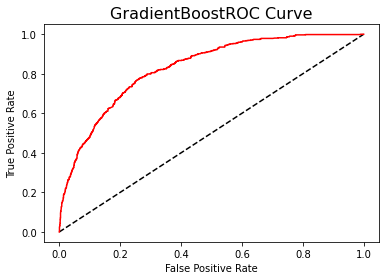

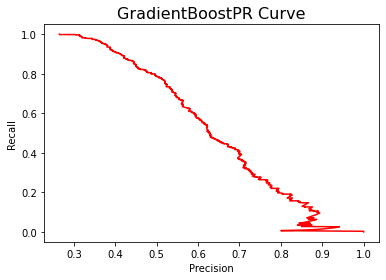

In [75]:
roc_curve_show(test_score['Churn'].astype('int').to_numpy(), test_score['prediction'].to_numpy(), 'GradientBoost')
pr_curve_show(test_score['Churn'].astype('int').to_numpy(), test_score['prediction'].to_numpy(), 'GradientBoost')

KS Table

In [76]:
ks(test_score, 'Churn')

ks


,Events,count,binned,lower_limit,upper_limit,NonEvents,Events_Dist,NonEvents_Dist,Events_Cumm,NonEvents_Cumm,Events_Cumm_num,NonEvents_Cumm_num,KS,Precision,Capture
9,173,235,"(0.675, 0.934]",0.67500,0.9340,62,0.280389,0.035776,0.280389,0.035776,173,62,2.446129e+01,0.736170,0.280389
8,123,235,"(0.52, 0.675]",0.52000,0.6750,112,0.199352,0.064628,0.479741,0.100404,296,174,3.793368e+01,0.629787,0.479741
7,101,235,"(0.388, 0.52]",0.38800,0.5200,134,0.163695,0.077323,0.643436,0.177726,397,308,4.657095e+01,0.563121,0.643436
6,83,235,"(0.26, 0.388]",0.26000,0.3880,152,0.134522,0.087709,0.777958,0.265436,480,460,5.125222e+01,0.510638,0.777958
5,44,235,"(0.162, 0.26]",0.16200,0.2600,191,0.071313,0.110214,0.849271,0.375649,524,651,4.736215e+01,0.445957,0.849271
4,38,235,"(0.0904, 0.162]",0.09040,0.1620,197,0.061588,0.113676,0.910859,0.489325,562,848,4.215341e+01,0.398582,0.910859
3,34,235,"(0.0465, 0.0904]",0.04650,0.0904,201,0.055105,0.115984,0.965964,0.605309,596,1049,3.606556e+01,0.362310,0.965964
2,10,235,"(0.0266, 0.0465]",0.02660,0.0465,225,0.016207,0.129833,0.982172,0.735141,606,1274,2.470304e+01,0.322340,0.982172
1,10,235,"(0.015, 0.0266]",0.01500,0.0266,225,0.016207,0.129833,0.998379,0.864974,616,1499,1.334052e+01,0.291253,0.998379
0,1,235,"(0.00522, 0.015]",0.00522,0.0150,234,0.001621,0.135026,1.000000,1.000000,617,1733,-1.110223e-14,0.262553,1.000000


Accuracy Score at maximum separation

In [ ]:
test_score['pred_lab'] = test_score['prediction'] >= 0.26

In [79]:
np.sum((test_score['Churn'].to_numpy()==test_score['pred_lab'].to_numpy()))*100/len(test_score)

74.55319148936171